In [15]:
import pandas as pd

# Load the file to check its structure and content
file_path = '../extracted/tender.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,tender_id,category,items
0,443159,Servicios Personales y Domesticos,"{""items"": [{""item"": 1, ""description"": ""Atenci\..."
1,439682,Servicios Personales y Domesticos,"{""items"": [{""item"": 1, ""description"": ""Servici..."
2,455319,Servicios Personales y Domesticos,"{""items"": [{""item"": 1, ""description"": ""Servici..."
3,445699,Servicios Personales y Domesticos,"{""items"": [{""item"": 1, ""description"": ""Servici..."
4,447045,Servicios Personales y Domesticos,"{""items"": [{""item"": 1, ""description"": ""Servici..."


In [16]:

import json

# Extract and structure the "items" column data
def extract_items(row):
    try:
        items = json.loads(row)['items']
        return [item['description'] for item in items]
    except (KeyError, TypeError, json.JSONDecodeError):
        return []

# Apply the function to the "items" column
data['item_descriptions'] = data['items'].apply(extract_items)

# Flatten the dataset to have one row per item description
items_data = data.explode('item_descriptions')[['tender_id', 'category', 'item_descriptions']]

# Drop rows with missing item descriptions
items_data = items_data.dropna(subset=['item_descriptions']).reset_index(drop=True)

# Display the structured data for items
items_data.head()

,tender_id,category,item_descriptions
0,443159,Servicios Personales y Domesticos,Atención integral para 50 niños
1,443159,Servicios Personales y Domesticos,Alimentación para 50 niños
2,443159,Servicios Personales y Domesticos,Personal de salud (1 Licenciado en Enfermería)
3,443159,Servicios Personales y Domesticos,Nutricionista
4,443159,Servicios Personales y Domesticos,Personal de limpieza (1 persona)


In [17]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# Custom stop words for Spanish (basic set, could be expanded)
spanish_stop_words = list(ENGLISH_STOP_WORDS) + [
    'que', 'de', 'el', 'la', 'los', 'las', 'un', 'una', 'y', 'en', 'para', 'por', 
    'con', 'del', 'al', 'se', 'lo', 'como', 'más', 'sin', 'su', 'a', 'es', 'o', 'sus'
]

# Re-run TF-IDF vectorization with the custom stop words
vectorizer = TfidfVectorizer(max_features=500, stop_words=spanish_stop_words)
item_embeddings = vectorizer.fit_transform(items_data['item_descriptions'])

# Convert sparse matrix to dense format for clustering
item_embeddings_dense = item_embeddings.toarray()

# Check the shape of the embeddings
item_embeddings_dense.shape

(7235, 500)

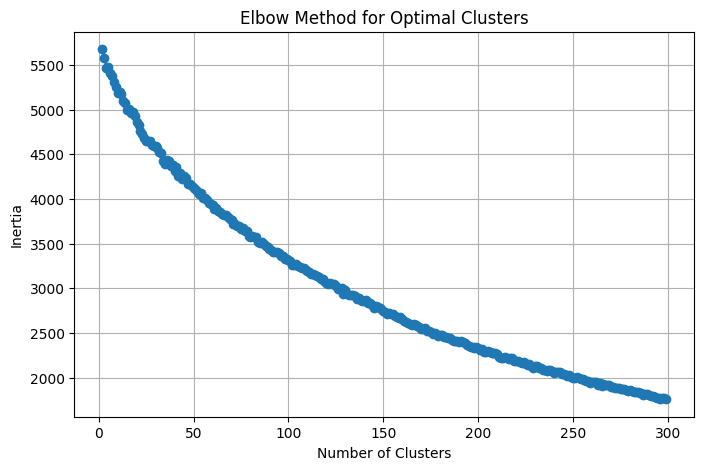

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(2, 300)  # Trying 2 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(item_embeddings_dense)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()


In [11]:
# Re-import necessary libraries and reload the file
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load the file
file_path = '../extracted/tender.csv'
data = pd.read_csv(file_path)

# Extract and structure the "items" column data
def extract_items(row):
    try:
        items = json.loads(row)['items']
        return [item['description'] for item in items]
    except (KeyError, TypeError, json.JSONDecodeError):
        return []

# Apply the function to the "items" column
data['item_descriptions'] = data['items'].apply(extract_items)

# Flatten the dataset to have one row per item description
items_data = data.explode('item_descriptions')[['tender_id', 'category', 'item_descriptions']]

# Drop rows with missing item descriptions
items_data = items_data.dropna(subset=['item_descriptions']).reset_index(drop=True)

# Generate embeddings using TF-IDF vectorization
spanish_stop_words = [
    'que', 'de', 'el', 'la', 'los', 'las', 'un', 'una', 'y', 'en', 'para', 'por', 
    'con', 'del', 'al', 'se', 'lo', 'como', 'más', 'sin', 'su', 'a', 'es', 'o', 'sus'
]
vectorizer = TfidfVectorizer(max_features=500, stop_words=spanish_stop_words)
item_embeddings = vectorizer.fit_transform(items_data['item_descriptions'])

# Convert sparse matrix to dense format for clustering
item_embeddings_dense = item_embeddings.toarray()

# Cluster with the chosen number of clusters (25)
optimal_clusters = 25
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
items_data['cluster'] = kmeans.fit_predict(item_embeddings_dense)

# Save the clustering output to a CSV file
output_path = '../clustered/clustered_items.csv'
items_data.to_csv(output_path, index=False)

output_path

'../clustered/clustered_items.csv'

In [14]:

# Re-import necessary libraries and reload the file
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load the new file
file_path = '../extracted/tender.csv'
data = pd.read_csv(file_path)

# Repeat the extraction process with item indices
def extract_items_with_index(row):
    try:
        items = json.loads(row)['items']
        return [{'description': item['description'], 'index': item['item']} for item in items]
    except (KeyError, TypeError, json.JSONDecodeError):
        return []

# Apply the updated function to the "items" column
data['item_details'] = data['items'].apply(extract_items_with_index)

# Flatten the dataset to have one row per item description with the item index
flat_items = data.explode('item_details')
flat_items = flat_items.dropna(subset=['item_details']).reset_index(drop=True)

flat_items['item_descriptions'] = flat_items['item_details'].apply(lambda x: x['description'])
flat_items['item_index'] = flat_items['item_details'].apply(lambda x: x['index'])

# Keep necessary columns only
flat_items_data = flat_items[['tender_id', 'category', 'item_index', 'item_descriptions']]

# Re-generate embeddings using TF-IDF vectorization
spanish_stop_words = [
    'que', 'de', 'el', 'la', 'los', 'las', 'un', 'una', 'y', 'en', 'para', 'por', 
    'con', 'del', 'al', 'se', 'lo', 'como', 'más', 'sin', 'su', 'a', 'es', 'o', 'sus'
]
vectorizer = TfidfVectorizer(max_features=500, stop_words=spanish_stop_words)
item_embeddings = vectorizer.fit_transform(flat_items_data['item_descriptions'])

# Cluster with the chosen number of clusters (25)
kmeans = KMeans(n_clusters=25, random_state=42, n_init=10)
flat_items_data['cluster'] = kmeans.fit_predict(item_embeddings.toarray())

# Save the updated clustering output to a new CSV file
output_path_final = '../clustered/clustered_items.csv'
flat_items_data.to_csv(output_path_final, index=False)

output_path_final

/var/folders/rl/lqnt2ld96wb6xvw28szh41d40000gn/T/ipykernel_75668/1989132876.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_items_data['cluster'] = kmeans.fit_predict(item_embeddings.toarray())


'../clustered/clustered_items.csv'